In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress
from matplotlib import pyplot as plt

import tensorflow as tf
# https://stackoverflow.com/questions/66814523/shap-deepexplainer-with-tensorflow-2-4-error
tf.compat.v1.disable_v2_behavior() 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

# from sklearn.model_selection import GroupKFold
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier


''' 
read the data 
'''

data = pd.read_csv('../data/a286935_data_chromatin_live.csv')
data = data[~data["comment"].isin(["stress_control"])]
data = data[~data["comment"].isin(["H2B"])]
data = data[data["guide"].str.contains('1398') | data["guide"].str.contains('1514')]
data = data[data["time"] < 40]

# initial filtering based on experimental setup

''' 
add features 
In a resulting table target column names start with a 't', while features to be used in training start with 'f'.
'''

data_agg = data.groupby(['file', 'particle']).agg(t_guide=('guide', 'first'),
                                                  t_time=('time', 'first'),
                                                  t_serum_conc_percent=('serum_conc_percent', 'first'),

                                                  f_mean_diff_xy_micron=('diff_xy_micron', 'mean'),
                                                  # average displacement
                                                  f_max_diff_xy_micron=('diff_xy_micron', 'max'),
                                                  # maximal displacement
                                                  f_sum_diff_xy_micron=('diff_xy_micron', 'sum'),
                                                  # total trajectory length
                                                  f_var_diff_xy_micron=('diff_xy_micron', 'var'),
                                                  # variance in displacements

                                                  sum_diff_x_micron=('diff_x_micron', 'sum'),
                                                  sum_diff_y_micron=('diff_y_micron', 'sum'),

                                                  f_area_micron=('area_micron', 'mean'),
                                                  f_perimeter_au_norm=('perimeter_au_norm', 'mean'),
                                                  # morphology

                                                  f_min_dist_micron=('min_dist_micron', 'mean'),
                                                  # minimal distance to edge averaged for each timelapse
                                                  min_min_dist_micron=('min_dist_micron', 'min'),
                                                  max_min_dist_micron=('min_dist_micron', 'max'),
                                                  beg_min_dist_micron=('min_dist_micron', 'first'),
                                                  end_min_dist_micron=('min_dist_micron', 'last'),
                                                  f_var_dist_micron=('min_dist_micron', 'var'),
                                                  )

data_agg['f_Rvar_diff_xy_micron'] = data_agg['f_var_diff_xy_micron']/data_agg['f_mean_diff_xy_micron']
data_agg['f_Rvar_dist_micron'] = data_agg['f_var_dist_micron']/data_agg['f_min_dist_micron']
# Relative variance

data_agg['f_total_displacement'] = np.sqrt((data_agg['sum_diff_x_micron']) ** 2 + (data_agg['sum_diff_y_micron']) ** 2)
# distance from first to last coordinate
data_agg['f_persistence'] = data_agg['f_total_displacement'] / data_agg['f_sum_diff_xy_micron']
# shows how directional the movement is

data_agg['file_mean_diff_xy_micron'] = data_agg.groupby('file')['f_mean_diff_xy_micron'].transform(np.max)
data_agg['f_fastest_mask'] = np.where((data_agg['f_mean_diff_xy_micron'] == data_agg['file_mean_diff_xy_micron']), 1, 0)
# DO NOT USE FOR guide AS TARGET (telo!)
# the fastest (or the only available) dot in the nucleus is 1, the rest is 0

data_agg['f_min_dist_range'] = data_agg['max_min_dist_micron'] - data_agg['min_min_dist_micron']
# min_dist change within timelapse (max-min) for each dot
data_agg['f_total_min_dist'] = data_agg['end_min_dist_micron'] - data_agg['beg_min_dist_micron']
# how distance changed within timelapse (frame29-frame0)

data_agg['file_max_min_dist_micron'] = data_agg.groupby('file')['f_min_dist_micron'].transform(np.max)
data_agg['f_most_central_mask'] = np.where((data_agg['f_min_dist_micron'] == data_agg['file_max_min_dist_micron']), 1,
                                           0)
# DO NOT USE FOR guide AS TARGET (telo!)
# the most central (or the only available) dot in the nucleus is 1, the rest is 0

data_slope = data.groupby(['file', 'particle']).apply(lambda x: linregress(x['frame'], x['min_dist_micron'])[0])
data_agg['f_slope_min_dist_micron'] = data_slope
# slope for minimal distance to edge; how distance to edge changes within the timelapse?


data_slope_area = data.groupby(['file', 'particle']).apply(lambda x: linregress(x['frame'], x['area_micron'])[0])
data_agg['f_slope_area_micron'] = data_slope_area
# slope for nucleus area; how area changes within the timelapse?

data_slope_perimeter = data.groupby(['file', 'particle']).apply(lambda x: linregress(x['frame'],
                                                                                     x['perimeter_au_norm'])[0])
data_agg['f_slope_perimeter_au_norm'] = data_slope_perimeter
# slope for nucleus perimeter

data_SD_diff_xy_micron = data.groupby(['file', 'particle']).agg(SD_diff=('diff_xy_micron', 'std'))
data_i = data.set_index(['file', 'particle'])
data_i['SD_diff_xy_micron'] = data_SD_diff_xy_micron
data_i['f_mean_diff_xy_micron'] = data_agg['f_mean_diff_xy_micron']
data_i['outliers2SD_diff_xy'] = np.where((data_i['diff_xy_micron'] >
                                          (data_i['f_mean_diff_xy_micron'] + 2 * data_i['SD_diff_xy_micron'])), 1, 0)
data_i['outliers3SD_diff_xy'] = np.where((data_i['diff_xy_micron'] >
                                          (data_i['f_mean_diff_xy_micron'] + 3 * data_i['SD_diff_xy_micron'])), 1, 0)
data_agg['f_outliers2SD_diff_xy'] = data_i.groupby(['file', 'particle']) \
    .agg(f_outliers2SD_diff_xy=('outliers2SD_diff_xy', 'sum'))
data_agg['f_outliers3SD_diff_xy'] = data_i.groupby(['file', 'particle']) \
    .agg(f_outliers3SD_diff_xy=('outliers3SD_diff_xy', 'sum'))
# is there a displacement larger than mean plus 2SD or 3SD (SD calculated for each dot, 29xy pairs) respectively

data_sterile = data_agg.drop(['sum_diff_x_micron',
                              'sum_diff_y_micron',
                              'min_min_dist_micron',
                              'max_min_dist_micron',
                              'beg_min_dist_micron',
                              'end_min_dist_micron',
                              'file_mean_diff_xy_micron',
                              'file_max_min_dist_micron',
                              'f_sum_diff_xy_micron', # proportional to f_mean_diff_xy_micron, thus, useless
                              ], axis=1)
data_sterile.reset_index(inplace=True)
corr_features = data_sterile.corr()

''' 
Train / test split
'''

features = [
           'f_mean_diff_xy_micron', 'f_max_diff_xy_micron', 'f_var_diff_xy_micron',
           'f_area_micron', 'f_perimeter_au_norm', 'f_min_dist_micron',
           'f_var_dist_micron', 'f_Rvar_diff_xy_micron', 'f_Rvar_dist_micron',
           'f_total_displacement', 'f_persistence', 'f_fastest_mask',
           'f_min_dist_range', 'f_total_min_dist', 'f_most_central_mask',
           'f_slope_min_dist_micron', 'f_slope_area_micron',
           'f_slope_perimeter_au_norm', 'f_outliers2SD_diff_xy',
           'f_outliers3SD_diff_xy'
            ]


tst = int((data_sterile['file'].unique().shape[0]) / 4)
# nuclei number to choose for testing

# test_choice = np.random.RandomState(7).choice(data_sterile['file'].unique(), tst, replace=False)

results = pd.DataFrame()

# save last model and train/test sets for SHAP
model = None
X_norm = None
X_test_norm = None

for i in range(30):
    test_choice = np.random.choice(data_sterile['file'].unique(), tst, replace=False)

    test_data = data_sterile[data_sterile['file'].isin(test_choice)]
    train_data = data_sterile[~data_sterile['file'].isin(test_choice)]
    train_data = train_data.dropna()

    X = train_data[features]

    y = train_data['t_serum_conc_percent']
    y = (y / 10).astype('int')  # binarize, '10% serum' = 1, '0.3% serum' = 0

    X_test = test_data[features]

    y_test = test_data['t_serum_conc_percent']
    y_test = (y_test / 10).astype('int')  # binarize, '10% serum' = 1, '0.3% serum' = 0

    X_norm = X / X.max(axis=0)
    X_test_norm = X_test / X.max(axis=0)  # devided by X.max but not X_test.max, so that normalization is the same

    print(X_norm.shape)
    #X_norm=tf.convert_to_tensor(X_norm)
    #print(X_norm.shape)
    
    #model = models.Sequential()
    #model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.Dense(1, activation='sigmoid'))

    input_layer = layers.Input(shape=(20,))
    layer1 = layers.Dense(64, activation='relu')(input_layer)
    layer2 = layers.Dense(64, activation='relu')(layer1)
    layer3 = layers.Dense(64, activation='relu')(layer2)
    output_layer= layers.Dense(1, activation="sigmoid")(layer3)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_norm,
                        y,
                        epochs=500,
                        # batch_size=50,
                        validation_data=(X_test_norm, y_test),
                        verbose=0,
                        )

    #results["acc" + str(i)] = history.history['accuracy']
    #results["val_acc" + str(i)] = history.history['val_accuracy']

    # print(1-y.sum()/len(y))
    print(1 - y_test.sum() / len(y_test))
    
    # no loop, playing with SHAP
    break

#dnn_results=results.iloc[:,range(1,60,2)]
#dnn_results['mean']=dnn_results.mean(axis=1)
#plt.plot(dnn_results['mean'])
#plt.show()

(226, 20)


/proj/hajaalin/Miniconda3/4.11.0/envs/tsc_jupyter2/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


0.381578947368421


In [3]:
print(model.input.shape)
print(model.output.shape)


(?, 20)
(?, 1)


In [6]:
import shap

# compute SHAP values
#explainer = shap.DeepExplainer(model, X_norm)
explainer = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), X_norm)
#explainer = shap.KernelExplainer(model.predict, X_norm)

# https://stackoverflow.com/questions/66814523/shap-deepexplainer-with-tensorflow-2-4-error
shap_values = explainer.shap_values(X_test_norm.to_numpy())

In [16]:
print(len(shap_values))

1


In [17]:
shap_values

[array([[-0.01182133,  0.02828831, -0.01537207, ..., -0.03520459,
         -0.0282255 ,  0.00559774],
        [-0.01093441, -0.01830555, -0.00479611, ..., -0.12233965,
         -0.02131126,  0.01874995],
        [-0.00805618,  0.00855958, -0.00882238, ..., -0.04619295,
          0.00068038,  0.00748145],
        ...,
        [-0.07182317,  0.18008664, -0.06872625, ..., -0.03685579,
          0.00653784,  0.03660546],
        [ 0.04798129,  0.06186041,  0.01093852, ...,  0.03696857,
          0.04894401,  0.03680345],
        [-0.02079777, -0.00833217, -0.00360287, ..., -0.02390595,
         -0.08065046,  0.01287905]])]

In [14]:
print(tf.__version__)
print(shap.__version__)

2.7.0
0.41.0


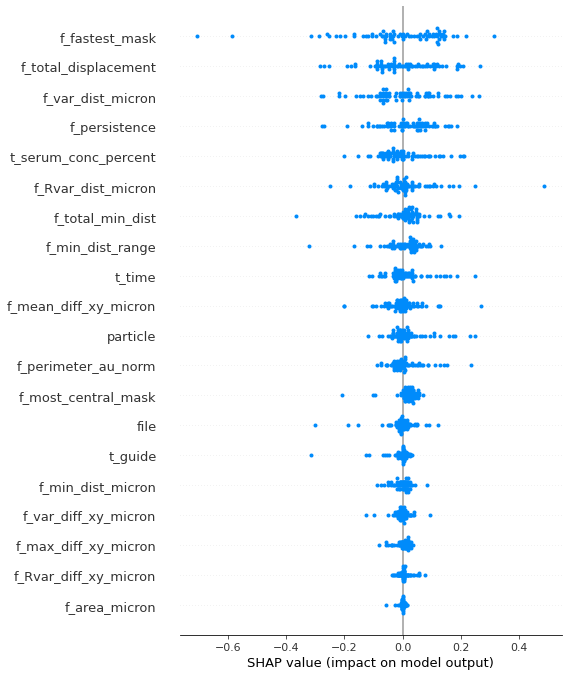

In [20]:
shap.summary_plot(shap_values[0], feature_names = test_data.columns)

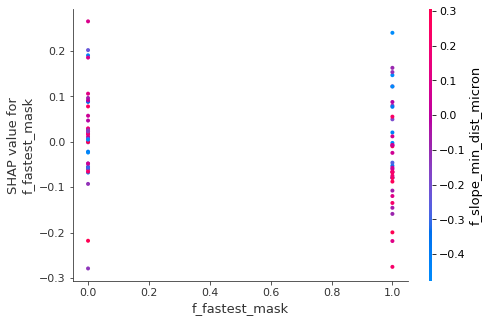

In [12]:
shap.dependence_plot("f_fastest_mask", shap_values[0], X_test_norm)

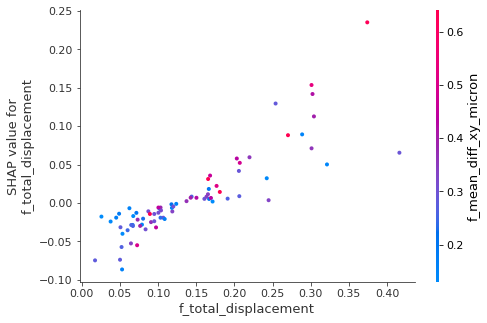

In [13]:
shap.dependence_plot("f_total_displacement", shap_values[0], X_test_norm)